In [56]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [57]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.driver.port,40483
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.driver.extraJavaOptions,-Dderby.system.home=/tmp/cgo82/spark/
spark.executor.id,driver
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.app.startTime,1717383753238


In [58]:
# Helper functions

def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("label").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

    
def with_custom_prediction(pred, threshold, probabilityCol="probability", customPredictionCol="customPrediction"):
    """
    """

    apply_custom_threshold_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())

    return pred.withColumn(customPredictionCol, apply_custom_threshold_udf(F.col(probabilityCol)))


def print_metrics(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'metrics for custom threshold')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')
    print(f'')
# Write your imports and code here or insert cells below



In [59]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.window import Window
from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, desc, count
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import sum, col
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

In [60]:
#Other imports to be used locally

import datetime

import numpy as np
import scipy as sp
import pandas as pd

np.set_printoptions(edgeitems=5, threshold=100, precision=4)

In [61]:
# Determine ideal number of partitions

conf = sc.getConf()

N = int(conf.get("spark.executor.instances"))
M = int(conf.get("spark.executor.cores"))
partitions = 4 * N * M

print(f'ideal # partitions = {partitions}')

ideal # partitions = 32


### # Song recommendations
In this section you will use the Taste Profile dataset to develop a song recommendation service based on collaborative filtering.
Collaborative filtering describes algorithms that generate songs recommendations for specific users based on the combined user-song play information from all users. These song recommendations are generated by embedding users and songs as numerical vectors in the same vector space, and selecting songs that are similar to the user based on cosine similarity.

## Q1

First it will be helpful to know more about the properties of the dataset before you being training
the collaborative filtering model.

In [62]:
#firstly, load the taste profile dataset
schema_triplets = StructType([
    StructField("user_id", StringType(), True),
    StructField("song_id",StringType(), True),
    StructField("play_count", IntegerType(), True)
])

# Load triplets data from HDFS
triplets = spark.read.csv("/data/msd/tasteprofile/triplets.tsv/", sep = '\t', schema = schema_triplets).repartition(partitions)
triplets.cache()

print('\n')
print(f'**Conclusion: The raw triplets table has {triplets.count()} rows.')
show_as_html(triplets, 5 )



**Conclusion: The raw triplets table has 48373586 rows.


,user_id,song_id,play_count
0,ac8864cc4de40a8cf9ee13283356459b0d1a7cf7,SOSYOHI12A8C144584,1
1,79f66be5c8406927d0f74703073ff8acb772795f,SOHASWV12A58A7DD76,1
2,f17290eac7e0318306d56ff862d762475c6b604f,SOPOUSZ12AB0182BBC,1
3,1a0fc011bdb09369afc1a646bc4827408c41566f,SOGTQNI12AB0184A5C,1
4,9d7e9d405220f6e7978a69ddfd7fc5610a757857,SOUROYR12A8C14311E,1


In [63]:
#Secondly, deal with matching related part 
#load the mismatched information
sid_mismatches = spark.read.text("hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt").repartition(partitions)
sid_mismatches.head(5)

[Row(value='ERROR: <SOSHAHT12A8AE498DF TRGHCMN128F42422EB> Gene Kelly  -  Heavenly Music  !=  Summer Stock feat. MGM Studio Orchestra  -  Little Brown Jug [In The Good Old Summertime_ 1949]'),
 Row(value="ERROR: <SOTVIGC12CF5F87EFA TRGLNBL128F9324F09>   -    !=  Lyfe Jennings  -  Let's Stay Together"),
 Row(value='ERROR: <SOMIVVH12A58A7A4F3 TRBAYLZ128F933841B>   -    !=  Daryl Hall & John Oates  -  You Make My Dreams'),
 Row(value='ERROR: <SOLPMEO12A8C136EC2 TRBWLFD128F4261A6A>   -    !=  Girl Talk  -  Friday Night'),
 Row(value='ERROR: <SOCVMRY12A8AE486A6 TRGEDPP128F428AE71> Eurythmics  -  When Tomorrow Comes  !=  USAF Concert Band and Singing Sergeants  -  Variations on a West Country Carol')]

In [64]:
sid_mismatches_3 = (sid_mismatches
                 .select(
                     F.substring(F.col('value'), 9,18).alias('song_id'),
                     F.substring(F.col('value'), 28,18).alias('track_id') ,
                     ))


sid_mismatches_3.printSchema()
show_as_html(sid_mismatches_3, 5)

print('\n')
print(f'**Conclusion: The sid_mismatches table has {sid_mismatches_3.count()} rows.')

root
 |-- song_id: string (nullable = true)
 |-- track_id: string (nullable = true)



,song_id,track_id
0,SOSHAHT12A8AE498DF,TRGHCMN128F42422EB
1,SOTVIGC12CF5F87EFA,TRGLNBL128F9324F09
2,SOMIVVH12A58A7A4F3,TRBAYLZ128F933841B
3,SOLPMEO12A8C136EC2,TRBWLFD128F4261A6A
4,SOCVMRY12A8AE486A6,TRGEDPP128F428AE71




**Conclusion: The sid_mismatches table has 19094 rows.


In [65]:
sid_matches_manually_accepted = spark.read.text('/data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt')
sid_matches_manually_accepted.head(5)

[Row(value='9d8'),
 Row(value='< ERROR: <SOFQHZM12A8C142342 TRMWMFG128F92FFEF2> Josipa Lisac  -  razloga  !=  Lisac Josipa  -  1000 razloga'),
 Row(value='19d17'),
 Row(value='< ERROR: <SODXUTF12AB018A3DA TRMWPCD12903CCE5ED> Lutan Fyah  -  Nuh Matter the Crisis Feat. Midnite  !=  Midnite  -  Nah Matter the Crisis'),
 Row(value='29d26')]

In [66]:
sid_matches_manually_accepted.createOrReplaceTempView('sid_matches_manually_accepted_v')

sid_matches_manually_accepted_2 = spark.sql(f"""select substr(value,11,18) as song_id
,substr(value,30,18) as track_id
from sid_matches_manually_accepted_v  
where value like '%ERROR%'          
          """) 

In [67]:
sid_matches_manually_accepted_2.show(5)

+------------------+------------------+
|           song_id|          track_id|
+------------------+------------------+
|SOFQHZM12A8C142342|TRMWMFG128F92FFEF2|
|SODXUTF12AB018A3DA|TRMWPCD12903CCE5ED|
|SOASCRF12A8C1372E6|TRMHIPJ128F426A2E2|
|SOITDUN12A58A7AACA|TRMHXGK128F42446AB|
|SOLZXUM12AB018BE39|TRMRSOF12903CCF516|
+------------------+------------------+
only showing top 5 rows



In [68]:
#deal with one situation: some matches are mistaken but manually accepted
sid_mismatches_outlier = sid_mismatches_3.join(
  sid_matches_manually_accepted_2,
  on = 'song_id',
  how="leftanti"
)

print(f'The raw count of mismatched song items: {sid_mismatches_outlier.count()}')
print(f'The new count of mismatched song items: {sid_mismatches_3.count()}')
print(f'There are {sid_mismatches_3.count() -sid_mismatches_outlier.count()} song items deleted.')

The raw count of mismatched song items: 19093
The new count of mismatched song items: 19094
There are 1 song items deleted.


In [69]:
triplets_new = triplets.join(
  sid_mismatches_outlier,
  on = 'song_id',
  how="leftanti"
)
print(f'***Conclusion: The new count of triplets: {triplets_new.count()}.')
print(f'After {triplets.count() -triplets_new.count()} rows are deleted from Taste Profile Dataset.')
show_as_html(triplets_new, 5)

***Conclusion: The new count of triplets: 45795111.
After 2578475 rows are deleted from Taste Profile Dataset.


,song_id,user_id,play_count
0,SOSYOHI12A8C144584,ac8864cc4de40a8cf9ee13283356459b0d1a7cf7,1
1,SOHASWV12A58A7DD76,79f66be5c8406927d0f74703073ff8acb772795f,1
2,SOPOUSZ12AB0182BBC,f17290eac7e0318306d56ff862d762475c6b604f,1
3,SOGTQNI12AB0184A5C,1a0fc011bdb09369afc1a646bc4827408c41566f,1
4,SOUROYR12A8C14311E,9d7e9d405220f6e7978a69ddfd7fc5610a757857,1


In [70]:
num_song_unique = triplets_new.select(F.col('song_id')).distinct().count()
num_user_unique = triplets_new.select(F.col('user_id')).distinct().count()

print(f'There are {num_song_unique} unique songs.')
print(f'There are {num_user_unique} unique users.')

There are 378310 unique songs.
There are 1019318 unique users.


(c)
How many different songs has the most active user played?
What is this as a percentage of the total number of unique songs in the dataset?

In [71]:
# most active user
most_active_users = triplets_new.groupBy("user_id").sum("play_count").withColumnRenamed("sum(play_count)", "total_play_count").orderBy(desc("total_play_count"))
most_active_users.show()

+--------------------+----------------+
|             user_id|total_play_count|
+--------------------+----------------+
|093cb74eb3c517c51...|           13074|
|119b7c88d58d0c6eb...|            9104|
|3fa44653315697f42...|            8025|
|a2679496cd0af9779...|            6506|
|d7d2d888ae04d16e9...|            6190|
|4ae01afa8f2430ea0...|            6153|
|b7c24f770be6b8028...|            5827|
|113255a012b2affea...|            5471|
|99ac3d883681e21ea...|            5385|
|6d625c6557df84b60...|            5362|
|6b36f65d2eb5579a8...|            5318|
|ec6dfcf19485cb011...|            5146|
|3325fe1d8da7b13dd...|            5100|
|281deab3afccc9062...|            5057|
|c1255748c06ee3f64...|            4977|
|18c1dd917693fd929...|            4883|
|6a58f480d522814c0...|            4764|
|3b93435988354b188...|            4625|
|c11dea7d1f4d227b9...|            4356|
|31cbbdbd5a1a6ef64...|            4320|
+--------------------+----------------+
only showing top 20 rows



In [72]:
most_active_user = most_active_users.first()
print(f"The most active user is {most_active_user['user_id']} with a play count of {most_active_user['total_play_count']}.")

The most active user is 093cb74eb3c517c5179ae24caf0ebec51b24d2a2 with a play count of 13074.


In [73]:
most_active_user_id = "093cb74eb3c517c5179ae24caf0ebec51b24d2a2"
most_active_user_df = triplets_new.filter(col("user_id") == most_active_user_id)

# Show the filtered DataFrame
most_active_user_df.show(5)

+------------------+--------------------+----------+
|           song_id|             user_id|play_count|
+------------------+--------------------+----------+
|SOZKNSB12A8C140F11|093cb74eb3c517c51...|         3|
|SOOHCUB12A58A7AD2C|093cb74eb3c517c51...|         3|
|SOBNVXI12A81C238A8|093cb74eb3c517c51...|         8|
|SOMMMFT12A67ADC119|093cb74eb3c517c51...|         1|
|SOAMEVJ12A6701E393|093cb74eb3c517c51...|         2|
+------------------+--------------------+----------+
only showing top 5 rows



In [74]:
most_active_user_unique_songs_count = most_active_user_df.select("song_id").distinct().count()

# Show the result
print(f"The number of unique songs for user ID {most_active_user_id} is {most_active_user_unique_songs_count}.")

The number of unique songs for user ID 093cb74eb3c517c5179ae24caf0ebec51b24d2a2 is 195.


In [75]:
percentage = (most_active_user_unique_songs_count/num_song_unique) * 100
print(f'This is as a {percentage:.3f}% percent of the total number of unique songs.')

This is as a 0.052% percent of the total number of unique songs.


(d) Visualize the distribution of song popularity and the distribution of user activity by collecting
the counts of user plays per song and the counts of song plays per user respectively, and
describe the shape of the distributions.

In [76]:
# Compute song popularity distribution (counts of user plays per song)
song_popularity_df = triplets_new.groupBy("song_id").agg(count("user_id").alias("user_plays_per_song")).orderBy(desc("user_plays_per_song"))
song_popularity_df.show()

+------------------+-------------------+
|           song_id|user_plays_per_song|
+------------------+-------------------+
|SOAXGDH12A8C13F8A1|              90444|
|SOBONKR12A58A7A7E0|              84000|
|SOSXLTC12AF72A7F54|              80656|
|SONYKOW12AB01849C9|              78353|
|SOEGIYH12A6D4FC0E3|              69487|
|SOLFXKT12AB017E3E0|              64229|
|SOFLJQZ12A6D4FADA6|              58610|
|SOUSMXX12AB0185C24|              53260|
|SOWCKVR12A8C142411|              52080|
|SOUVTSM12AC468F6A7|              51022|
|SOTWNDJ12A8C143984|              47011|
|SOPUCYA12A8C13A694|              46078|
|SOHTKMO12AB01843B0|              46077|
|SOKLRPJ12A8C13C3FE|              45495|
|SOCVTLJ12A6310F0FD|              42535|
|SOPPROJ12AB0184E18|              41811|
|SOBOUPA12A6D4F81F1|              41093|
|SOPTLQL12AB018D56F|              40497|
|SOOFYTN12A6D4F9B35|              40403|
|SOBOAFP12A8C131F36|              39851|
+------------------+-------------------+
only showing top

In [77]:
song_popularity_pd = song_popularity_df.toPandas()

In [78]:
song_popularity_pd.head(5)

,song_id,user_plays_per_song
0,SOAXGDH12A8C13F8A1,90444
1,SOBONKR12A58A7A7E0,84000
2,SOSXLTC12AF72A7F54,80656
3,SONYKOW12AB01849C9,78353
4,SOEGIYH12A6D4FC0E3,69487


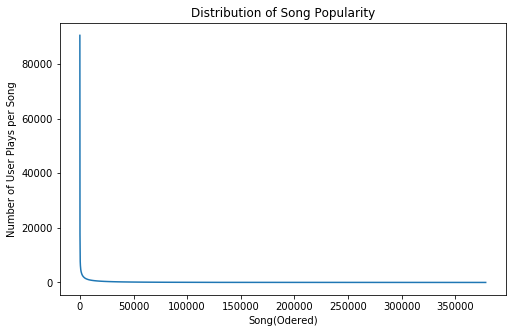

In [79]:
plt.figure(figsize=(8,5))
plt.plot(song_popularity_pd['user_plays_per_song'])
plt.title('Distribution of Song Popularity')
plt.xlabel('Song(Odered)')
plt.ylabel('Number of User Plays per Song')
plt.show()

In [80]:
# Compute user activity distribution (counts of song plays per user)
user_activity_df = triplets_new.groupBy("user_id").agg(count("song_id").alias("song_plays_per_user")).orderBy(desc("song_plays_per_user"))
user_activity_df.show()

+--------------------+-------------------+
|             user_id|song_plays_per_user|
+--------------------+-------------------+
|ec6dfcf19485cb011...|               4316|
|8cb51abc6bf8ea293...|               1562|
|5a3417a1955d91364...|               1557|
|fef771ab021c20018...|               1545|
|c1255748c06ee3f64...|               1498|
|4e73d9e058d2b1f2d...|               1470|
|cbc7bddbe3b2f59fd...|               1457|
|96f7b4f800cafef33...|               1407|
|b7c24f770be6b8028...|               1364|
|119b7c88d58d0c6eb...|               1362|
|a05e548059abb1f77...|               1324|
|6d625c6557df84b60...|               1307|
|33a1286454a3cff06...|               1304|
|d7d2d888ae04d16e9...|               1257|
|7e543508a213f4f22...|               1196|
|1aa4fd215aadb1609...|               1192|
|4e11f45d732f48617...|               1184|
|0c2932cb475b83b61...|               1182|
|db6a78c78c9239aba...|               1177|
|18765abd13462c176...|               1173|
+----------

In [81]:
user_activity_pd = user_activity_df.toPandas()

In [82]:
user_activity_pd.head(5)

,user_id,song_plays_per_user
0,ec6dfcf19485cb011e0b22637075037aae34cf26,4316
1,8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc,1562
2,5a3417a1955d9136413e0d293cd36497f5e00238,1557
3,fef771ab021c200187a419f5e55311390f850a50,1545
4,c1255748c06ee3f6440c51c439446886c7807095,1498


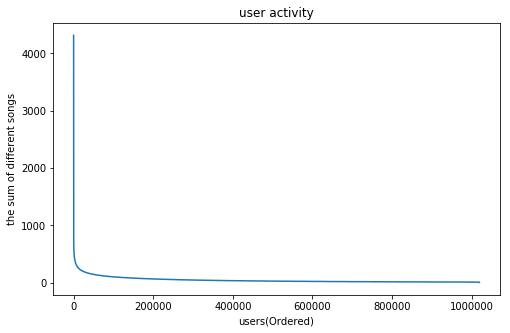

In [83]:
plt.figure(figsize=(8,5))
plt.plot(user_activity_pd['song_plays_per_user'])
plt.title( "user activity")
plt.xlabel('users(Ordered)')
plt.ylabel('the sum of different songs')
plt.show()

# Q2
Next you will train the collaborative filtering model.


(a)
Collaborative filtering determines similar users and songs based on their combined play history. Songs which have been played only a few times and users who have only listened to a few songs will not contribute much information and are unlikely to improve the model. Create a clean dataset of user-song plays by removing songs which have been played less than N times and users who have listened to fewer than M songs in total. Choose sensible values for N and M, taking into account the total number of users and songs.

In [84]:
#Firstly, analysis these two distributions
print('distribution of song popularity')
with pd.option_context('display.float_format', '{:0.2f}'.format):
   print(song_popularity_pd.describe())

print('distribution of user activity')
with pd.option_context('display.float_format', '{:0.2f}'.format):
   print(user_activity_pd.describe())

distribution of song popularity
       user_plays_per_song
count            378310.00
mean                121.05
std                 748.65
min                   1.00
25%                   4.00
50%                  13.00
75%                  50.00
max               90444.00
distribution of user activity
       song_plays_per_user
count           1019318.00
mean                 44.93
std                  54.91
min                   3.00
25%                  15.00
50%                  26.00
75%                  53.00
max                4316.00


In [85]:
song_popularity_pd_filtered = song_popularity_pd[song_popularity_pd['user_plays_per_song']>121]
with pd.option_context('display.float_format', '{:0.2f}'.format):
   print(song_popularity_pd_filtered.describe())

user_activity_pd_filtered = user_activity_pd[user_activity_pd['song_plays_per_user']>45]
with pd.option_context('display.float_format', '{:0.2f}'.format):
   print(user_activity_pd_filtered.describe())

       user_plays_per_song
count             55648.00
mean                706.16
std                1845.32
min                 122.00
25%                 184.00
50%                 307.00
75%                 632.25
max               90444.00
       song_plays_per_user
count            298388.00
mean                102.47
std                  73.38
min                  46.00
25%                  59.00
50%                  79.00
75%                 118.00
max                4316.00


In [86]:
song_popularity_filtered = spark.createDataFrame(song_popularity_pd_filtered)
stringIndexer_songs = StringIndexer(inputCol="song_id", outputCol="song_code", stringOrderType="frequencyDesc")
song_fit = stringIndexer_songs.fit(song_popularity_filtered)
song_popularity_filtered = song_fit.transform(song_popularity_filtered)

song_popularity_filtered.show(5)

+------------------+-------------------+---------+
|           song_id|user_plays_per_song|song_code|
+------------------+-------------------+---------+
|SOAXGDH12A8C13F8A1|              90444|   2034.0|
|SOBONKR12A58A7A7E0|              84000|   3531.0|
|SOSXLTC12AF72A7F54|              80656|  41344.0|
|SONYKOW12AB01849C9|              78353|  31002.0|
|SOEGIYH12A6D4FC0E3|              69487|   9676.0|
+------------------+-------------------+---------+
only showing top 5 rows



In [87]:
user_activity_filtered = spark.createDataFrame(user_activity_pd_filtered)
stringIndexer_songs = StringIndexer(inputCol="user_id", outputCol="user_code", stringOrderType="frequencyDesc")
user_fit = stringIndexer_songs.fit(user_activity_filtered)
user_activity_filtered = user_fit.transform(user_activity_filtered)
user_activity_filtered.show(5)

+--------------------+-------------------+---------+
|             user_id|song_plays_per_user|user_code|
+--------------------+-------------------+---------+
|ec6dfcf19485cb011...|               4316| 275381.0|
|8cb51abc6bf8ea293...|               1562| 163220.0|
|5a3417a1955d91364...|               1557| 104706.0|
|fef771ab021c20018...|               1545| 297151.0|
|c1255748c06ee3f64...|               1498| 224743.0|
+--------------------+-------------------+---------+
only showing top 5 rows



In [88]:
# merge
triplets_merge = triplets_new.join(song_popularity_filtered, on='song_id',how='left')\
.filter(F.col('song_code').isNotNull())\
.join(user_activity_filtered, on='user_id',how='left')\
.filter(F.col('user_code').isNotNull())\
.drop( 'user_plays_per_song', 'song_plays_per_user' )
triplets_merge.show(10)

+--------------------+------------------+----------+---------+---------+
|             user_id|           song_id|play_count|song_code|user_code|
+--------------------+------------------+----------+---------+---------+
|0030bfca05740e85c...|SOBXHDL12A81C204C0|         5|   4331.0|    207.0|
|0030bfca05740e85c...|SOIZFTE12AB0186842|         3|  20202.0|    207.0|
|0030bfca05740e85c...|SOPJHQC12A6701F6CB|         5|  33995.0|    207.0|
|0030bfca05740e85c...|SOKQOJY12AAF3B531C|         2|  23894.0|    207.0|
|0030bfca05740e85c...|SOMNGMO12A6702187E|         1|  27918.0|    207.0|
|0030bfca05740e85c...|SORJICW12A8C13640D|         1|  38133.0|    207.0|
|0030bfca05740e85c...|SOBFRNE12A6D4F7995|         1|   2748.0|    207.0|
|0030bfca05740e85c...|SOEYVHS12AB0181D31|         1|  11304.0|    207.0|
|0030bfca05740e85c...|SOKBJJO12A8C140826|         1|  22611.0|    207.0|
|0030bfca05740e85c...|SOBLSTM12A8C140FC9|         1|   3280.0|    207.0|
+--------------------+------------------+----------

(b)
Split the dataset into training and test sets. The test set should contain at least 25% of the plays in total. Note that due to the nature of the collaborative filtering model, you must ensure that every user in the test set has some user-song plays in the training set as well. Explain why this is required and how you have done this while keeping the selection as random as possible.

In [89]:
criteria = triplets_merge.agg(F.sum("play_count")).collect()[0][0] * 0.25
print("25% of total plays of the full dataset is {}".format(criteria))

25% of total plays of the full dataset is 17658957.5


In [90]:
# Calculate the total play count
total_play_count = triplets_merge.agg(F.sum("play_count")).collect()[0][0]

In [91]:
# Determine the threshold for the test set (25% of total play count)
test_play_count_threshold = total_play_count * 0.25
test_play_count_threshold

17658957.5

In [92]:
# Randomly split the dataset into initial training and test sets (75% train, 25% test)
train_df, test_df = triplets_merge.randomSplit([0.75, 0.25], seed=42)

In [93]:
# Calculate the play count in the test set
test_play_count = test_df.agg(sum("play_count")).collect()[0][0]

In [94]:
test_play_count

17685403

In [95]:
import random
from pyspark.sql.functions import sum, col, rand

In [96]:
columns = ["user_id", "song_id", "play_count", "song_code", "user_code"]

In [97]:
# Adjust the test set if it doesn't meet the play count threshold
while test_play_count < test_play_count_threshold:
    # Calculate remaining play count needed
    remaining_play_count_needed = test_play_count_threshold - test_play_count
    
    # Take random rows from the training set until the threshold is met
    additional_rows = train_df.orderBy(rand()).limit(10000).collect()  # Use a smaller batch size
    
    # Convert additional rows to DataFrame
    additional_rows_df = spark.createDataFrame(additional_rows, columns)
    
    # Add these rows to the test set
    test_df = test_df.union(additional_rows_df)
    
    # Remove these rows from the training set
    train_df = train_df.subtract(additional_rows_df)

In [98]:
test_play_count = test_df.agg(sum("play_count")).collect()[0][0]

print(f"Test set actual play count: {test_play_count}")

Test set actual play count: 17685403


In [99]:
test_percentage = (test_play_count /total_play_count) * 100
print(f'The test set contains {test_percentage}% of the plays in total.')

The test set contains 25.037439214630876% of the plays in total.


In [100]:
# Show the first few rows of each set
train_df.show(5)
test_df.show(5)

+--------------------+------------------+----------+---------+---------+
|             user_id|           song_id|play_count|song_code|user_code|
+--------------------+------------------+----------+---------+---------+
|0030bfca05740e85c...|SOAZPPR12A6D4F89C6|         4|   2228.0|    207.0|
|0030bfca05740e85c...|SOBCMUG12AB017D50A|         1|   2483.0|    207.0|
|0030bfca05740e85c...|SOBLSTM12A8C140FC9|         1|   3280.0|    207.0|
|0030bfca05740e85c...|SOBONKR12A58A7A7E0|         1|   3531.0|    207.0|
|0030bfca05740e85c...|SOBOUPA12A6D4F81F1|        12|   3552.0|    207.0|
+--------------------+------------------+----------+---------+---------+
only showing top 5 rows

+--------------------+------------------+----------+---------+---------+
|             user_id|           song_id|play_count|song_code|user_code|
+--------------------+------------------+----------+---------+---------+
|0030bfca05740e85c...|SOBFRNE12A6D4F7995|         1|   2748.0|    207.0|
|0030bfca05740e85c...|SOBX

In [101]:
train_df.cache()
test_df.cache()

DataFrame[user_id: string, song_id: string, play_count: int, song_code: double, user_code: double]

(c)
Use the spark.ml library to train an implicit matrix factorization model using Alternating Least Squares (ALS).

In [102]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import DoubleType

# Cast "play_count" 
train_df = train_df.withColumn("play_count", train_df["play_count"].cast(DoubleType()))


als = ALS(maxIter=5, regParam=0.01, userCol="user_code", itemCol="song_code", ratingCol="play_count", 
          implicitPrefs=True, coldStartStrategy="drop")

# training 
als_model = als.fit(train_df)

(d)
Select a few of the users from the test set by hand and use the model to generate some recommendations. Compare these recommendations to the songs the user has actually played. Comment on the effectiveness of the collaborative filtering model.

In [103]:
user_code = '104706.0'
user_1 = test_df.select(F.col("*")).filter(F.col("user_code") == user_code)
user_1.cache()

user_1.show(15)

+--------------------+------------------+----------+---------+---------+
|             user_id|           song_id|play_count|song_code|user_code|
+--------------------+------------------+----------+---------+---------+
|5a3417a1955d91364...|SOASNQV12A8AE48819|         1|   1634.0| 104706.0|
|5a3417a1955d91364...|SOBAXIM12A6D4F8C47|         1|   2337.0| 104706.0|
|5a3417a1955d91364...|SOBBTUB12A67020389|         1|   2415.0| 104706.0|
|5a3417a1955d91364...|SOBCADW12A8C13AB68|         1|   2439.0| 104706.0|
|5a3417a1955d91364...|SOBHWEK12A6701EB1A|         1|   2941.0| 104706.0|
|5a3417a1955d91364...|SOBLDDB12AB0183223|         1|   3232.0| 104706.0|
|5a3417a1955d91364...|SOCDGPD12AF72A8346|         1|   4878.0| 104706.0|
|5a3417a1955d91364...|SOCLYAC12AF72A99DD|         1|   5594.0| 104706.0|
|5a3417a1955d91364...|SOCOTVS12A6D4F6061|         1|   5807.0| 104706.0|
|5a3417a1955d91364...|SOCQIFO12A58A7B74C|         1|   5949.0| 104706.0|
|5a3417a1955d91364...|SOCRNTA12A8C13CCB6|         1

In [104]:
# Predict relevance scores
pred_user_1 = als_model.transform(user_1)
pred_user_1.cache()

pred_user_1.printSchema()
pred_user_1.show(15)

root
 |-- user_id: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- play_count: integer (nullable = true)
 |-- song_code: double (nullable = true)
 |-- user_code: double (nullable = true)
 |-- prediction: float (nullable = false)

+--------------------+------------------+----------+---------+---------+-------------+
|             user_id|           song_id|play_count|song_code|user_code|   prediction|
+--------------------+------------------+----------+---------+---------+-------------+
|5a3417a1955d91364...|SOCOTVS12A6D4F6061|         1|   5807.0| 104706.0| 0.0050949175|
|5a3417a1955d91364...|SOFHATE12A6D4FB15D|         1|  11983.0| 104706.0| 0.0022668783|
|5a3417a1955d91364...|SOJZZUX12A8C13FC44|         1|  22497.0| 104706.0| 0.0072238296|
|5a3417a1955d91364...|SOGYZGS12A6D4F83F7|         1|  15849.0| 104706.0|  0.017082313|
|5a3417a1955d91364...|SONRFMM12A58A77F4A|         1|  30392.0| 104706.0| 0.0061356877|
|5a3417a1955d91364...|SOUUEGD12A58A8024E|         1| 

In [105]:
!hdfs dfs -du -h /data/msd/

12.3 G   98.1 G   /data/msd/audio
30.1 M   241.0 M  /data/msd/genre
174.4 M  1.4 G    /data/msd/main
490.4 M  3.8 G    /data/msd/tasteprofile


In [109]:
main_summary_df = spark.read.format("csv").option("header", "true").load("hdfs:///data/msd/main/summary/metadata.csv.gz")
main_count = main_summary_df.count()
print(f"Number of rows in Main/Summary Dataset: {main_count}")

Number of rows in Main/Summary Dataset: 1000000


In [110]:
# Import necessary functions
from pyspark.sql.functions import explode, col
from pyspark.sql.types import DoubleType, StructType, StructField, FloatType, ArrayType

# Ensure main_summary_df is cached
main_summary_df.cache()

# Join user history with metadata
user_history_with_metadata = user_1.join(
    main_summary_df.select("song_id", "title", "artist_name"),
    on="song_id",
    how="left"
)

# Show the user history with metadata
user_history_with_metadata.show(20000)

+------------------+--------------------+----------+---------+---------+--------------------+--------------------+
|           song_id|             user_id|play_count|song_code|user_code|               title|         artist_name|
+------------------+--------------------+----------+---------+---------+--------------------+--------------------+
|SOETILF12A6310E26B|5a3417a1955d91364...|         1|  10795.0| 104706.0|     Take Everything|          Mazzy Star|
|SOJEKRF12A8C133CC3|5a3417a1955d91364...|         1|  20625.0| 104706.0|          No_ No_ No|     Destiny's Child|
|SOOMRQC12A67021882|5a3417a1955d91364...|         1|  32194.0| 104706.0|       Opening Title|      Massive Attack|
|SOQVQSG12A8C13C64E|5a3417a1955d91364...|         1|  37093.0| 104706.0|      Among The Dead|       Tim Armstrong|
|SOVWEZE12A6701DF46|5a3417a1955d91364...|         1|  47329.0| 104706.0|Insomnia And The ...|                Live|
|SOWALWE12A58A7E37D|5a3417a1955d91364...|         1|  47652.0| 104706.0|Hippy Hi

In [111]:
# Generate recommendations

k = 15

recommendations_1 = als_model.recommendForAllUsers(k)

recommendations_1.printSchema()
recommendations_1.cache()
recommendations_1.show()

root
 |-- user_code: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- song_code: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)

+---------+--------------------+
|user_code|     recommendations|
+---------+--------------------+
|       12|[{41725, 0.230370...|
|       18|[{34562, 0.231026...|
|       38|[{9676, 0.502154}...|
|       70|[{27357, 0.084006...|
|       93|[{9676, 0.3521191...|
|      190|[{27357, 0.088144...|
|      218|[{17580, 0.334366...|
|      273|[{29480, 0.137816...|
|      300|[{34562, 0.045260...|
|      340|[{34867, 1.034727...|
|      343|[{6414, 0.3763514...|
|      412|[{3531, 0.1767929...|
|      434|[{2034, 0.0658657...|
|      475|[{29480, 0.344008...|
|      536|[{26990, 0.064332...|
|      585|[{2034, 0.6217163...|
|      600|[{4038, 0.3778083...|
|      611|[{29683, 0.242981...|
|      615|[{9676, 0.3912971...|
|      619|[{2034, 0.6144342...|

In [112]:
# Collect and sort relevant items in order of descending relevance 

relevant_1 = (
    user_1
    .groupBy("user_code")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("play_count"),
                F.col("song_code"),
            )
        ))).alias("relevant")
    )
)
relevant_1.printSchema()
relevant_1.cache()
relevant_1.show()

root
 |-- user_code: double (nullable = true)
 |-- relevant: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- play_count: integer (nullable = true)
 |    |    |-- song_code: double (nullable = true)

+---------+--------------------+
|user_code|            relevant|
+---------+--------------------+
| 104706.0|[{3, 42442.0}, {3...|
+---------+--------------------+



In [113]:
# Merge recommendations 

comparison_1 = (
    recommendations_1
    .select(
        F.col("user_code"),
        F.col("recommendations.song_code").alias("recommendations").astype(ArrayType(IntegerType())),
    )
    .join(
        relevant_1
        .select(
            F.col("user_code"),
            F.col("relevant.song_code").alias("relevant").astype(ArrayType(IntegerType())),
        ),
        on="user_code",
        how="inner"
    )
)
comparison_1.cache()

comparison_1.printSchema()
show_as_html(comparison_1)

root
 |-- user_code: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: integer (containsNull = true)



,user_code,recommendations,relevant
0,104706,"[34562, 44044, 42581, 11930, 26549, 7211, 1673...","[42442, 10138, 52150, 49135, 47201, 43198, 423..."


In [114]:
comparison_1_p = comparison_1.toPandas()

In [115]:
comparison_1_p.columns

list_recomd = pd.DataFrame( list( str(comparison_1_p.loc[0,'recommendations']).replace('[','')
                                 .replace(']','').split(',')))
list_test = pd.DataFrame( list( str(comparison_1_p.loc[0,'relevant']).replace('[','')
                                 .replace(']','').split(',')))

compare_1 = pd.concat([list_recomd, list_test], axis=1)
compare_1.columns = ['list_recomd', 'list_test']
compare_1

,list_recomd,list_test
0,34562,42442
1,44044,10138
2,42581,52150
3,11930,49135
4,26549,47201
5,7211,43198
6,16733,42333
7,23395,39834
8,19736,36861
9,30859,36241


(e)
Use the test set of user-song plays and recommendations from the collaborative filtering model to compute the following metrics • Precision @ 10 • NDCG @ 10 • Mean Average Precision (MAP) Look up these metrics and explain why they are useful in evaluating the collaborate filtering model. Explore the limitations of these metrics in evaluating a collaborative filtering model or recommendation service in general. Suggest an alternative method for comparing two recommendation services in the real world.

In [116]:
pred = als_model.transform(test_df)
pred.cache()

pred.printSchema()
pred.show()

root
 |-- user_id: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- play_count: integer (nullable = true)
 |-- song_code: double (nullable = true)
 |-- user_code: double (nullable = true)
 |-- prediction: float (nullable = false)

+--------------------+------------------+----------+---------+---------+-------------+
|             user_id|           song_id|play_count|song_code|user_code|   prediction|
+--------------------+------------------+----------+---------+---------+-------------+
|c29ae8fd2c48e3142...|SOAAEKX12A6D4F7E4E|         1|     12.0| 226483.0|  0.020912442|
|282fc5ca91b28ac48...|SOAAEKX12A6D4F7E4E|         1|     12.0|  46531.0| 0.0032266434|
|6eb129b20f5b473b0...|SOAAEKX12A6D4F7E4E|         2|     12.0| 128537.0| 0.0042245993|
|14ac74ac4d09240a6...|SOAAEKX12A6D4F7E4E|         1|     12.0|  23734.0| 0.0017103793|
|7304f4d978b4de466...|SOAAEKX12A6D4F7E4E|         1|     12.0| 133537.0| 0.0022400485|
|eb7a7afbc3f05ecda...|SOAAEKX12A6D4F7E4E|         1| 

In [117]:
# Generate recommendations
k = 10

recommendations = als_model.recommendForAllUsers(k)

recommendations.printSchema()
show_as_html(recommendations)

root
 |-- user_code: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- song_code: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



,user_code,recommendations
0,12,"[(41725, 0.23037013411521912), (42581, 0.22573..."
1,18,"[(34562, 0.23102664947509766), (16733, 0.21259..."
2,38,"[(9676, 0.5021539926528931), (41344, 0.4741265..."
3,70,"[(27357, 0.08400643616914749), (40727, 0.07312..."
4,93,"[(9676, 0.35211917757987976), (31633, 0.337439..."
5,190,"[(27357, 0.08814482390880585), (49111, 0.07939..."
6,218,"[(17580, 0.33436641097068787), (35514, 0.33349..."
7,273,"[(29480, 0.13781611621379852), (1119, 0.115473..."
8,300,"[(34562, 0.045260634273290634), (1119, 0.04496..."
9,340,"[(34867, 1.034727931022644), (44030, 1.0036746..."


In [118]:
relevant = (
    test_df
    .groupBy("user_code")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("play_count"),
                F.col("song_code"),
            )
        ))).alias("relevant")
    )
)
relevant.printSchema()
relevant.cache()
show_as_html(relevant)

root
 |-- user_code: double (nullable = true)
 |-- relevant: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- play_count: integer (nullable = true)
 |    |    |-- song_code: double (nullable = true)



,user_code,relevant
0,6.0,"[(4, 1569.0), (3, 10323.0), (2, 34976.0), (2, ..."
1,13.0,"[(2, 298.0), (1, 50113.0), (1, 44015.0), (1, 4..."
2,99.0,"[(1, 55198.0), (1, 50978.0), (1, 46093.0), (1,..."
3,106.0,"[(6, 11102.0), (5, 35097.0), (5, 27454.0), (4,..."
4,122.0,"[(15, 25770.0), (9, 15354.0), (9, 13186.0), (8..."
5,194.0,"[(2, 35186.0), (2, 13310.0), (2, 9891.0), (1, ..."
6,196.0,"[(11, 45882.0), (5, 45948.0), (5, 298.0), (3, ..."
7,209.0,"[(2, 33229.0), (1, 38220.0), (1, 18042.0), (1,..."
8,215.0,"[(7, 31200.0), (7, 15001.0), (5, 32795.0), (3,..."
9,350.0,"[(7, 30280.0), (6, 40273.0), (2, 17151.0), (1,..."


In [119]:
# Merge recommendations and relevant items so they can be compared

temp = (
    recommendations
    .select(
        F.col("user_code"),
        F.col("recommendations.song_code").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("user_code"),
            F.col("relevant.song_code").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="user_code",
        how="inner"
    )
)
temp.cache()

temp.printSchema()
show_as_html(temp)

root
 |-- user_code: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: double (containsNull = true)



,user_code,recommendations,relevant
0,12,"[41725.0, 42581.0, 9676.0, 3531.0, 41344.0, 12...","[25893.0, 13941.0, 11695.0, 7211.0, 3835.0, 41..."
1,18,"[34562.0, 16733.0, 25610.0, 31684.0, 27805.0, ...","[30871.0, 27746.0, 45907.0, 41366.0, 23362.0, ..."
2,38,"[9676.0, 41344.0, 31633.0, 34867.0, 3531.0, 12...","[46714.0, 31633.0, 9791.0, 3531.0, 41492.0, 35..."
3,70,"[27357.0, 40727.0, 49111.0, 34867.0, 24228.0, ...","[52601.0, 33099.0, 4065.0, 33081.0, 52247.0, 5..."
4,93,"[9676.0, 31633.0, 27040.0, 34867.0, 34494.0, 5...","[25566.0, 22201.0, 23905.0, 8433.0, 38744.0, 3..."
5,190,"[27357.0, 49111.0, 34867.0, 31684.0, 48110.0, ...","[2619.0, 1304.0, 36756.0, 31785.0, 27469.0, 24..."
6,218,"[17580.0, 35514.0, 3552.0, 29480.0, 44654.0, 7...","[1267.0, 53057.0, 5702.0, 16798.0, 43631.0, 19..."
7,273,"[29480.0, 1119.0, 35514.0, 35127.0, 23499.0, 3...","[18511.0, 30165.0, 5296.0, 42678.0, 2023.0, 53..."
8,300,"[34562.0, 1119.0, 35872.0, 35127.0, 29480.0, 2...","[17617.0, 32488.0, 19690.0, 12748.0, 398.0, 53..."
9,340,"[34867.0, 44030.0, 9676.0, 31633.0, 12366.0, 1...","[34867.0, 37838.0, 41450.0, 43875.0, 38621.0, ..."


In [68]:
from pyspark.ml.evaluation import RankingEvaluator

k = 10

evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluator.evaluate(temp, {evaluator.metricName: "precisionAtK",            evaluator.k: k})
mapAtK       = evaluator.evaluate(temp, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK      = evaluator.evaluate(temp, {evaluator.metricName: "ndcgAtK",                 evaluator.k: k})

print(f'metrics')
print(f'precision {precisionAtK:.5f}')
print(f'MAP {mapAtK:.5f}')
print(f'NDCG  {ndcgAtK:.5f}')

metrics
precision 0.04772
MAP 0.01947
NDCG  0.05125


In [120]:
stop_spark()